#LOAD DATA DARI DRIVE

## Mount google drive

Sambungkan Google Drive Anda ke Google Colab agar Anda dapat mengakses file gambar.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

folder_path = '/content/drive/My Drive/ComputersVision/Kelompok4'

# Periksa apakah folder ada dan daftar isinya
if os.path.exists(folder_path):
    print(f"Daftar file di: {folder_path}")
    try:
        all_files = os.listdir(folder_path)
        print("File ditemukan:")
        for file in all_files:
            print(file)
    except Exception as e:
        print(f"Terjadi kesalahan saat mendaftar file: {e}")
else:
    print(f"Error: Jalur folder '{folder_path}' tidak ditemukan. Pastikan jalurnya benar dan Google Drive sudah terpasang.")

Daftar file di: /content/drive/My Drive/ComputersVision/Kelompok4
File ditemukan:
Sesi 1 (12.20)
SESI 2 (24.00)
SESI 3 (12.00)
NIR SESI 1
NIR SESI 2
NIR SESI 3
glcm_results
augmentasi
rice_classification_model.h5


#IMAGE PRE-PROCESSING (HAPUS BACKGROUND)
Menghapus background dan mengganti background dengan #000

## Install rembg library

Pasang library `rembg` yang diperlukan untuk penghapusan latar belakang.


In [3]:
!pip install rembg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.9 MB/s eta 0:00:00


## Load original images

Muat gambar asli dari subfolder di dalam folder Google Drive yang Anda tentukan.


In [4]:
# Definisikan jalur ke folder utama di Google Drive Anda yang berisi subfolder dengan gambar.
main_folder_path = '/content/drive/My Drive/ComputersVision/Kelompok4'

# Buat daftar kosong untuk menyimpan jalur semua file gambar yang ditemukan.
original_image_paths = []

# Iterasi melalui setiap item (file dan subfolder) di folder utama.
for item_name in os.listdir(main_folder_path):
    item_path = os.path.join(main_folder_path, item_name)

    # Untuk setiap item, periksa apakah itu adalah direktori.
    if os.path.isdir(item_path):
        # Jika itu adalah direktori, iterasi melalui file di dalam subfolder tersebut.
        for filename in os.listdir(item_path):
            # Untuk setiap file di dalam subfolder, periksa apakah ekstensinya adalah format gambar umum.
            if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
                # Jika itu adalah file gambar, buat jalur lengkap ke gambar tersebut dan tambahkan ke daftar jalur gambar.
                image_path = os.path.join(item_path, filename)
                original_image_paths.append(image_path)

# Setelah mengiterasi melalui semua subfolder dan file, daftar akan berisi jalur ke semua gambar asli.
print(f"Ditemukan {len(original_image_paths)} gambar asli.")
# cetak daftar jalur gambar (opsional, untuk verifikasi)
# for img_path in original_image_paths:
# print(img_path)

Ditemukan 150 gambar asli.


## Preprocess images (background removal & replacement with rembg)

Iterasi melalui setiap gambar yang dimuat:
- Gunakan `rembg` untuk menghapus latar belakang gambar, menghasilkan gambar dengan latar belakang transparan.
- Ganti latar belakang transparan dengan warna hitam solid (#000).
- Pastikan resolusi gambar tetap 3024x4032.


In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.6 MB/s eta 0:00:00


In [ ]:
import cv2
import os
import numpy as np
from rembg import remove
from PIL import Image

# Definisikan jalur folder utama untuk gambar asli
main_input_folder = '/content/drive/My Drive/ComputersVision/Kelompok4'

# Definisikan jalur folder output untuk gambar yang diproses
output_folder_path = '/content/drive/My Drive/ComputersVision/Kelompok4/augmentasi'

# Buat folder output dasar jika belum ada
os.makedirs(output_folder_path, exist_ok=True)

# Iterasi melalui setiap image_path dalam daftar original_image_paths (dari langkah sebelumnya)
for image_path in original_image_paths:
    try:
        # Baca gambar menggunakan cv2.imread()
        image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)

        if image is None:
            print(f"Warning: Tidak dapat memuat gambar {image_path}. Melewati.")
            continue

        # Simpan dimensi asli
        original_height, original_width = image.shape[:2]

        # Periksa jumlah channel dalam gambar yang dimuat.
        if len(image.shape) < 3:
             # Konversi grayscale ke BGR untuk konsistensi sebelum mengkonversi ke PIL
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
            print(f"Mengkonversi gambar grayscale {image_path} ke BGR.")
        elif image.shape[2] == 4: # Jika memiliki channel alpha (BGRA)
             # Konversi BGRA ke BGR untuk pemrosesan rembg jika diperlukan.
             # rembg biasanya menghasilkan RGBA atau Pillow Image, jadi kita akan menangani alpha setelah menghapus.
             # Tidak diperlukan konversi di sini sebelum meneruskan ke PIL fromarray untuk RGBA.
             pass


        # Konversi ke Pillow Image untuk rembg
        if image.shape[2] == 3: # BGR
            img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        elif image.shape[2] == 4: # BGRA
             img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA))
        else:
             print(f"Warning: Gambar {image_path} memiliki jumlah channel yang tidak didukung ({image.shape[2]}). Melewati.")
             continue


        # Terapkan penghapusan latar belakang menggunakan rembg.remove()
        output_pil = remove(img_pil)

        # Konversi output Pillow Image kembali ke format OpenCV (RGBA)
        output_image_rgba = cv2.cvtColor(np.array(output_pil), cv2.COLOR_RGBA2BGRA)

        # Buat gambar latar belakang hitam solid dengan dimensi asli dan 4 channel (BGRA)
        black_background = np.full((original_height, original_width, 4), (0, 0, 0, 255), dtype=np.uint8) # BGRA hitam

        # Campurkan latar belakang hitam dengan gambar yang diproses
        # Gunakan channel alpha untuk mencampur
        alpha_channel = output_image_rgba[:, :, 3] / 255.0
        alpha_mask = cv2.merge([alpha_channel, alpha_channel, alpha_channel])

        # Campurkan foreground (gambar yang diproses) dan background (hitam)
        blended_image_bgr = (output_image_rgba[:, :, :3] * alpha_mask + black_background[:, :, :3] * (1 - alpha_mask)).astype(np.uint8)

        # --- Pertahankan resolusi asli ---
        # Tidak perlu mengubah ukuran karena kita membuat black_background dengan dimensi asli
        processed_image_to_save = blended_image_bgr
        # --- Akhir Pertahankan resolusi asli ---


        # Buat jalur output dengan mempertahankan struktur subfolder
        # Dapatkan jalur relatif dari folder input utama
        relative_path = os.path.relpath(image_path, main_input_folder)
        # Buat jalur output lengkap dengan menggabungkan folder dasar output dan jalur relatif
        output_image_path = os.path.join(output_folder_path, relative_path)

        # Buat subfolder di direktori output jika belum ada
        output_subfolder = os.path.dirname(output_image_path)
        os.makedirs(output_subfolder, exist_ok=True)


        # Simpan gambar yang diproses ke jalur output
        # Simpan sebagai PNG untuk mempertahankan potensi channel alpha jika tidak sepenuhnya buram (meskipun latar belakang hitam seharusnya membuatnya buram)
        # Atau simpan sebagai JPG jika alpha tidak diperlukan (ukuran file lebih kecil) - mari kita tetap menggunakan ekstensi asli
        original_filename = os.path.basename(image_path) # Get the original filename
        file_extension = os.path.splitext(original_filename)[1]
        if file_extension.lower() in ['.png', '.gif']: # Save with alpha if original was PNG/GIF
             cv2.imwrite(output_image_path, output_image_rgba) # Save RGBA output from rembg directly
        else: # Save as BGR for other formats like JPG
             cv2.imwrite(output_image_path, processed_image_to_save)


        # Cetak pesan yang menunjukkan keberhasilan pemrosesan dan penyimpanan setiap gambar
        print(f"Diproses dan disimpan: {output_image_path}")

    except Exception as e:
        print(f"Error memproses {image_path}: {e}")
        continue # Lanjutkan ke gambar berikutnya bahkan jika satu gagal

#AUGMENTASI GAMBAR

In [ ]:
import os
import cv2
import numpy as np
import albumentations as A
from PIL import Image # Import PIL for saving different image types

# Define the path to the main folder in your Google Drive containing the subfolders with images.
main_folder_path = '/content/drive/My Drive/ComputersVision/Kelompok4'

# Define the path to the output folder for augmented images
output_folder_path = '/content/drive/My Drive/ComputersVision/Kelompok4/augmentasi'

# Create the base output folder if it doesn't exist
os.makedirs(output_folder_path, exist_ok=True)

# List the subfolders you want to augment within the main_folder_path
# These should be the folders containing your original images for augmentation
subfolders_to_augment = ["Sesi 1 (12.20)", "SESI 2 (24.00)", "SESI 3 (12.00)", "NIR SESI 1", "NIR SESI 2", "NIR SESI 3"]


# Mendefinisikan augmentasi yang akan digunakan
transform = A.Compose([
    A.Rotate(limit=25, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomBrightnessContrast(
        brightness_limit=0.3, contrast_limit=0.3, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
    A.RandomGamma(gamma_limit=(80, 120), p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1,
                       rotate_limit=0, p=0.5),
    A.CropAndPad(percent=(-0.1, 0.1), p=0.5),
    A.Blur(blur_limit=3, p=0.3)
])

# Fungsi untuk melakukan augmentasi pada sebuah folder
def augment_folder(input_folder_path, output_base_folder, target_count=250):
    # Membuat daftar semua file gambar di folder
    image_files = [f for f in os.listdir(input_folder_path) if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif"))]
    print(f"\nMemproses folder: {os.path.basename(input_folder_path)}")
    print(f"Jumlah gambar awal: {len(image_files)}")

    # Membaca semua gambar
    images = []
    valid_image_files = []
    for image_file in image_files:
        img_path = os.path.join(input_folder_path, image_file)
        img = cv2.imread(img_path) # Read in color by default
        if img is not None:
            images.append(img)
            valid_image_files.append(image_file)
        else:
            print(f"Gagal membaca gambar: {image_file}")

    print(f"Jumlah gambar yang berhasil dibaca: {len(images)}")

    # Jika tidak ada gambar yang berhasil dibaca, skip folder ini
    if len(images) == 0:
        print(f"Tidak ada gambar yang dapat diproses di folder {input_folder_path}")
        return

    # Menghitung berapa banyak augmentasi yang diperlukan per gambar
    current_count = len(images)
    # Calculate augmentations needed to reach target_count
    augmentations_needed = max(0, target_count - current_count)
    if current_count > 0:
         augmentations_per_image = augmentations_needed // current_count
         remainder = augmentations_needed % current_count
    else:
         augmentations_per_image = 0
         remainder = 0


    print(f"Melakukan setidaknya {augmentations_per_image} augmentasi per gambar untuk mencapai target {target_count}")

    # Create the output subfolder
    output_subfolder = os.path.join(output_base_folder, os.path.basename(input_folder_path))
    os.makedirs(output_subfolder, exist_ok=True)

    # Melakukan augmentasi dan menyimpan gambar
    augmented_count = 0
    for i, image in enumerate(images):
        # Melakukan augmentasi sebanyak yang diperlukan per gambar
        num_aug_for_this_image = augmentations_per_image + (1 if i < remainder else 0)

        for j in range(num_aug_for_this_image):
            if current_count + augmented_count >= target_count:
                break

            # Mengaplikasikan augmentasi
            augmented = transform(image=image)
            augmented_image = augmented["image"]

            # Membuat nama file baru
            base_name = os.path.splitext(valid_image_files[i])[0]
            new_filename = f"{base_name}_aug_{augmented_count+1}.jpg" # Added underscore for clarity
            new_filepath = os.path.join(output_subfolder, new_filename)

            # Menyimpan gambar hasil augmentasi
            try:
                # Use PIL to save the image for better format handling
                img_pil = Image.fromarray(cv2.cvtColor(augmented_image, cv2.COLOR_BGR2RGB))
                img_pil.save(new_filepath)
                augmented_count += 1

                if (current_count + augmented_count) % 50 == 0:
                    print(f"Telah dibuat {current_count + augmented_count} gambar total (termasuk asli)")

            except Exception as e:
                 print(f"Gagal menyimpan gambar {new_filepath}: {e}")


        if current_count + augmented_count >= target_count:
            break

    print(
        f"Augmentasi selesai untuk folder {os.path.basename(input_folder_path)}! Total gambar sekarang (termasuk asli): {current_count + augmented_count}")


# Memproses setiap subfolder yang ditentukan
for folder_name in subfolders_to_augment:
    folder_path = os.path.join(main_folder_path, folder_name)
    if os.path.exists(folder_path) and os.path.isdir(folder_path):
        # Pass both the input folder path and the base output folder path
        augment_folder(folder_path, output_folder_path, target_count=250) # Set target count per folder
    else:
        print(f"Folder {folder_path} tidak ditemukan atau bukan direktori! Skipping.")

print("\nAugmentasi selesai untuk semua folder yang ditentukan!")

/tmp/ipython-input-3834105290.py:28: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)



Memproses folder: Sesi 1 (12.20)
Jumlah gambar awal: 30
Jumlah gambar yang berhasil dibaca: 30
Melakukan setidaknya 7 augmentasi per gambar untuk mencapai target 250
Telah dibuat 50 gambar total (termasuk asli)
Telah dibuat 100 gambar total (termasuk asli)
Telah dibuat 150 gambar total (termasuk asli)
Telah dibuat 200 gambar total (termasuk asli)
Telah dibuat 250 gambar total (termasuk asli)
Augmentasi selesai untuk folder Sesi 1 (12.20)! Total gambar sekarang (termasuk asli): 250

Memproses folder: SESI 2 (24.00)
Jumlah gambar awal: 30
Jumlah gambar yang berhasil dibaca: 30
Melakukan setidaknya 7 augmentasi per gambar untuk mencapai target 250
Telah dibuat 50 gambar total (termasuk asli)
Telah dibuat 100 gambar total (termasuk asli)
Telah dibuat 150 gambar total (termasuk asli)
Telah dibuat 200 gambar total (termasuk asli)
Telah dibuat 250 gambar total (termasuk asli)
Augmentasi selesai untuk folder SESI 2 (24.00)! Total gambar sekarang (termasuk asli): 250

Memproses folder: SESI 3 

#EKSTRAKSI FITUR

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
from skimage import feature
from skimage.util import img_as_ubyte
import matplotlib.pyplot as plt


# Fungsi untuk menghitung rata-rata nilai RGB dari gambar penuh
def extract_rgb_from_image(image):
    B, G, R = cv2.split(image)
    mean_R = np.mean(R)
    mean_G = np.mean(G)
    mean_B = np.mean(B)
    return mean_R, mean_G, mean_B

# Fungsi untuk menghitung fitur GLCM dari channel gambar


def calculate_glcm_features(image_channel):
    bins = np.array([0, 16, 32, 48, 64, 80, 96, 112, 128,
                     144, 160, 176, 192, 208, 224, 240, 255])
    inds = np.digitize(image_channel, bins)
    max_value = inds.max() + 1
    glcm = feature.graycomatrix(inds, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4],
                                levels=max_value, normed=True, symmetric=True)

    contrast = feature.graycoprops(glcm, 'contrast')
    dissimilarity = feature.graycoprops(glcm, 'dissimilarity')
    homogeneity = feature.graycoprops(glcm, 'homogeneity')
    energy = feature.graycoprops(glcm, 'energy')
    correlation = feature.graycoprops(glcm, 'correlation')
    asm = feature.graycoprops(glcm, 'ASM')

    # Hitung Entropi
    glcm = glcm + 1e-10  # Tambahan kecil agar tidak log(0)
    entropy = -np.sum(glcm * np.log2(glcm))

    return np.mean(contrast), np.mean(dissimilarity), np.mean(homogeneity), np.mean(energy), np.mean(correlation), np.mean(asm), entropy


# Fungsi untuk memproses semua gambar dalam satu folder
def process_images_in_folder(folder_path, output_csv):
    results = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not load image {image_path}. Skipping.")
                continue

            # Hitung fitur RGB
            mean_R, mean_G, mean_B = extract_rgb_from_image(image)

            # Ekstrak channel warna (pastikan gambar bukan grayscale)
            if len(image.shape) < 3:
                 print(f"Warning: Image {image_path} is grayscale. Skipping GLCM calculation on color channels.")
                 # You might want to calculate GLCM on the single channel here if needed
                 continue # Skip if expecting color images for color channel GLCM

            red_channel = img_as_ubyte(image[:, :, 2])
            green_channel = img_as_ubyte(image[:, :, 1])
            blue_channel = img_as_ubyte(image[:, :, 0])

            # Hitung fitur GLCM per channel
            contrast_R, dissimilarity_R, homogeneity_R, energy_R, correlation_R, asm_R, entropy_R = calculate_glcm_features(
                red_channel)
            contrast_G, dissimilarity_G, homogeneity_G, energy_G, correlation_G, asm_G, entropy_G = calculate_glcm_features(
                green_channel)
            contrast_B, dissimilarity_B, homogeneity_B, energy_B, correlation_B, asm_B, entropy_B = calculate_glcm_features(
                blue_channel)

            results.append({
                'filename': filename,
                'mean_R': mean_R,
                'mean_G': mean_G,
                'mean_B': mean_B,
                'contrast_R': contrast_R,
                'dissimilarity_R': dissimilarity_R,
                'homogeneity_R': homogeneity_R,
                'energy_R': energy_R,
                'correlation_R': correlation_R,
                'asm_R': asm_R,
                'entropy_R': entropy_R,
                'contrast_G': contrast_G,
                'dissimilarity_G': dissimilarity_G,
                'homogeneity_G': homogeneity_G,
                'energy_G': energy_G,
                'correlation_G': correlation_G,
                'asm_G': asm_G,
                'entropy_G': entropy_G,
                'contrast_B': contrast_B,
                'dissimilarity_B': dissimilarity_B,
                'homogeneity_B': homogeneity_B,
                'energy_B': energy_B,
                'correlation_B': correlation_B,
                'asm_B': asm_B,
                'entropy_B': entropy_B
            })

    if results: # Only save if there are results
        df = pd.DataFrame(results)
        df.to_csv(output_csv, index=False)
        print(f'Hasil telah disimpan ke {output_csv}')
    else:
        print(f'Tidak ada gambar yang diproses di folder {folder_path}')


# Fungsi untuk memproses semua subfolder
def process_all_folders(main_folder_path, output_folder_path):
    os.makedirs(output_folder_path, exist_ok=True)
    for folder_name in os.listdir(main_folder_path):
        folder_path = os.path.join(main_folder_path, folder_name)
        # Check if it's a directory and not the output folder itself
        if os.path.isdir(folder_path) and folder_path != output_folder_path:
            output_csv = f'{folder_name}_glcm_result.csv'
            output_csv_path = os.path.join(output_folder_path, output_csv)
            print(f"Processing folder: {folder_name}")
            process_images_in_folder(folder_path, output_csv_path)
        elif os.path.isfile(folder_path):
             print(f"Skipping file: {folder_name}")


# Jalankan proses
main_folder_path = '/content/drive/My Drive/ComputersVision/Kelompok4/augmentasi' # Updated to Google Drive path
output_folder_path = '/content/drive/My Drive/ComputersVision/Kelompok4/augmentasi/glcm_results' # Updated to a path within Google Drive
process_all_folders(main_folder_path, output_folder_path)

Processing folder: Sesi 1 (12.20)
Hasil telah disimpan ke /content/drive/My Drive/ComputersVision/Kelompok4/augmentasi/glcm_results/Sesi 1 (12.20)_glcm_result.csv
Processing folder: SESI 2 (24.00)
Hasil telah disimpan ke /content/drive/My Drive/ComputersVision/Kelompok4/augmentasi/glcm_results/SESI 2 (24.00)_glcm_result.csv
Processing folder: SESI 3 (12.00)
Hasil telah disimpan ke /content/drive/My Drive/ComputersVision/Kelompok4/augmentasi/glcm_results/SESI 3 (12.00)_glcm_result.csv
Processing folder: NIR SESI 1
Hasil telah disimpan ke /content/drive/My Drive/ComputersVision/Kelompok4/augmentasi/glcm_results/NIR SESI 1_glcm_result.csv
Processing folder: NIR SESI 2
Hasil telah disimpan ke /content/drive/My Drive/ComputersVision/Kelompok4/augmentasi/glcm_results/NIR SESI 2_glcm_result.csv
Processing folder: NIR SESI 3
Hasil telah disimpan ke /content/drive/My Drive/ComputersVision/Kelompok4/augmentasi/glcm_results/NIR SESI 3_glcm_result.csv


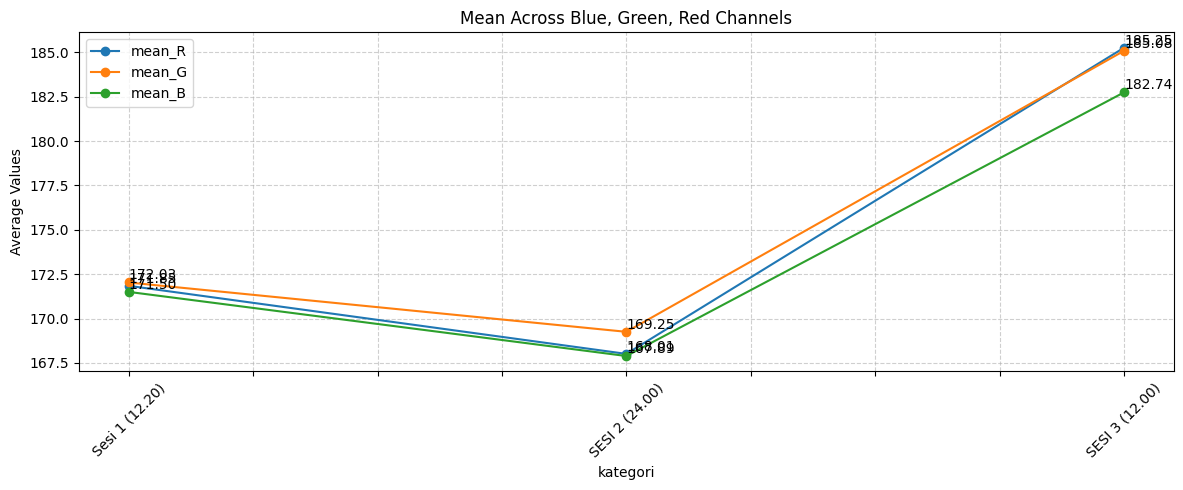

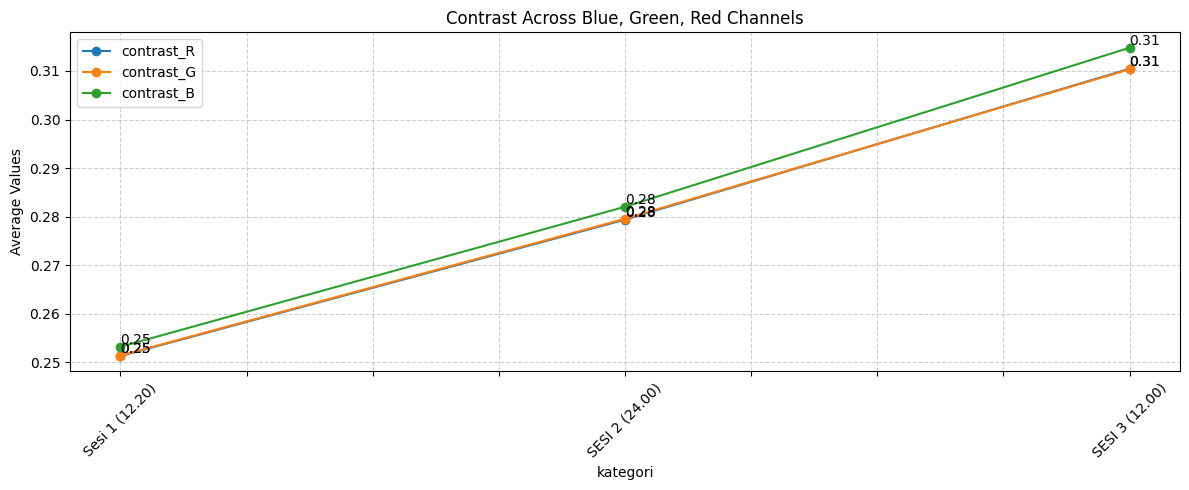

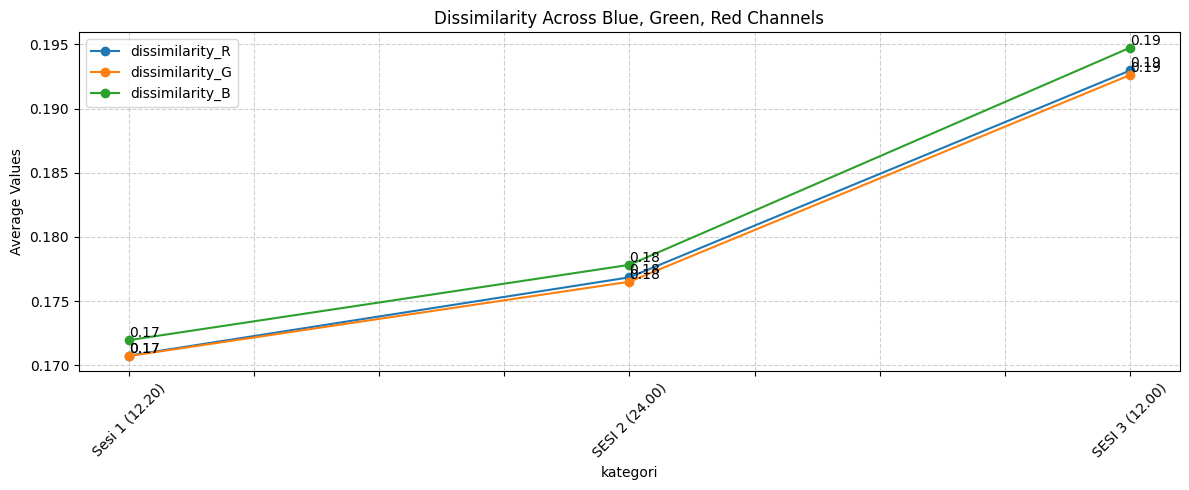

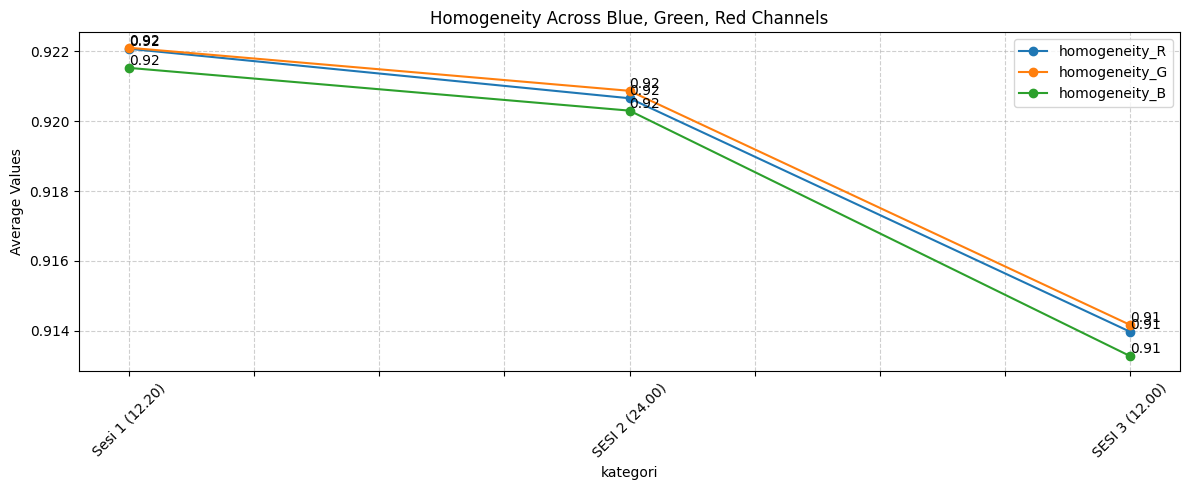

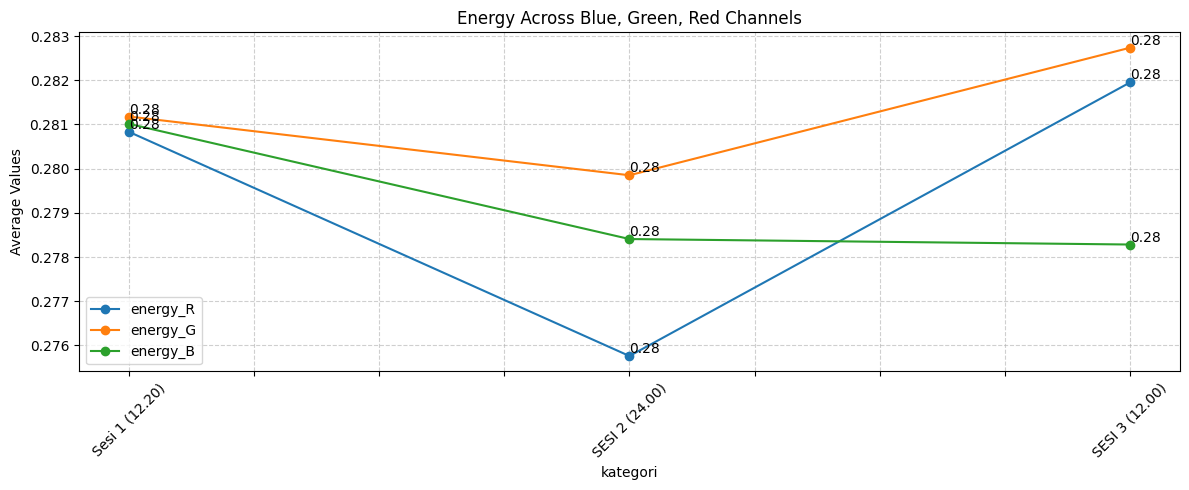

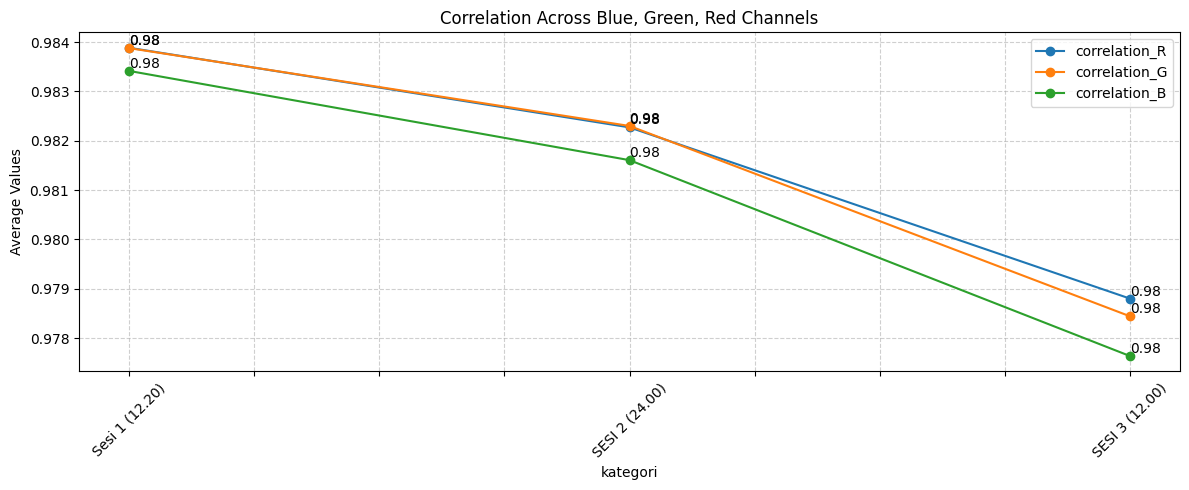

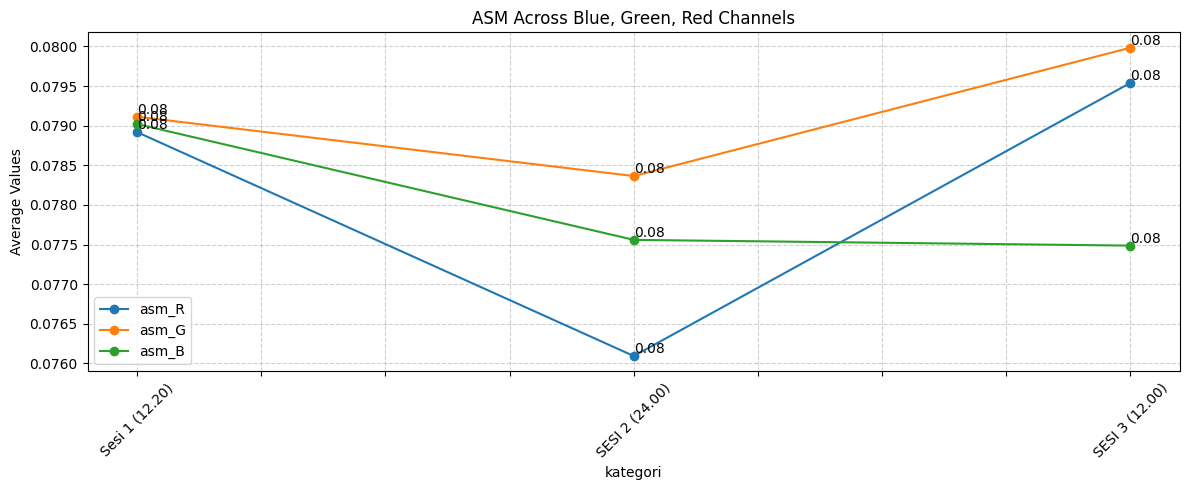

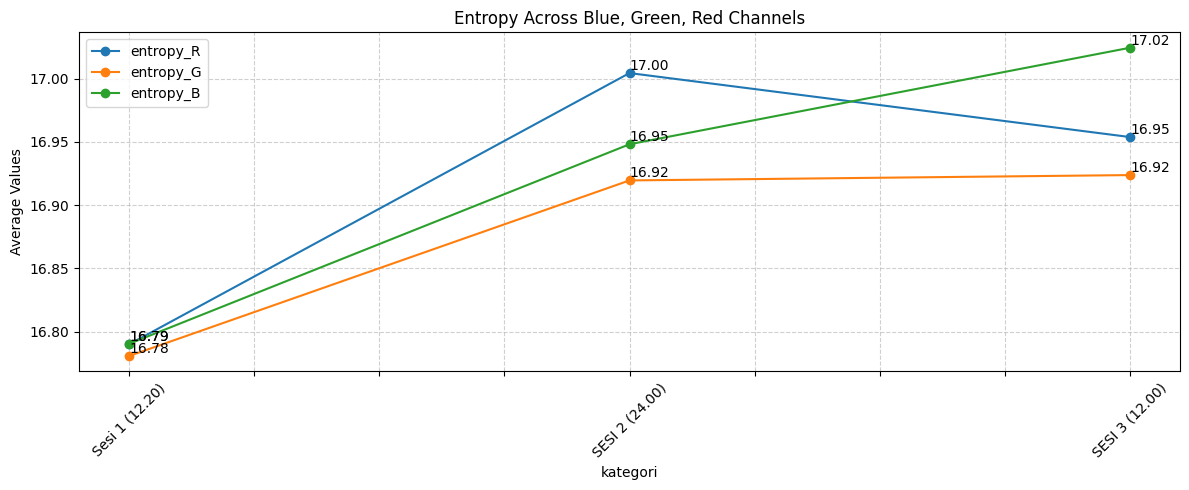

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# Definisikan jalur ke folder yang berisi file CSV hasil GLCM
glcm_results_folder = '/content/drive/My Drive/ComputersVision/Kelompok4/augmentasi/glcm_results' # Jalur yang diperbarui

# Dapatkan daftar semua file CSV di folder yang ditentukan
all_csv_files = glob.glob(os.path.join(glcm_results_folder, '*.csv'))

# Filter file yang TIDAK mengandung "NIR" dalam nama filenya
file_list = [f for f in all_csv_files if "NIR" not in os.path.basename(f)]

# Ekstrak label dari nama file (hapus _glcm_result.csv dan jalurnya)
kategori_labels = [os.path.basename(f).replace('_glcm_result.csv', '') for f in file_list]


df_list = []
for file, label in zip(file_list, kategori_labels):
    try:
        temp = pd.read_csv(file)
        temp["kategori"] = label
        df_list.append(temp)
    except Exception as e:
        print(f"Error membaca file {file}: {e}")
        continue


if df_list:
    df = pd.concat(df_list, ignore_index=True)

    fitur_groups = {
        "Mean": ["mean_R", "mean_G", "mean_B"],
        "Contrast": ["contrast_R", "contrast_G", "contrast_B"],
        "Dissimilarity": ["dissimilarity_R", "dissimilarity_G", "dissimilarity_B"],
        "Homogeneity": ["homogeneity_R", "homogeneity_G", "homogeneity_B"],
        "Energy": ["energy_R", "energy_G", "energy_B"],
        "Correlation": ["correlation_R", "correlation_G", "correlation_B"],
        "ASM": ["asm_R", "asm_G", "asm_B"],
        "Entropy": ["entropy_R", "entropy_G", "entropy_B"]
    }

    # Definisikan urutan kategori yang diinginkan untuk plotting
    category_order = ['Sesi 1 (12.20)', 'SESI 2 (24.00)', 'SESI 3 (12.00)']

    for fitur, cols in fitur_groups.items():
        # Periksa apakah kolom ada di DataFrame sebelum plotting
        valid_cols = [col for col in cols if col in df.columns]
        if not valid_cols:
            print(f"Melewati plot untuk {fitur}: Kolom {cols} tidak ditemukan di DataFrame.")
            continue

        plt.figure(figsize=(12, 5))
        # Kelompokkan berdasarkan 'kategori' dan hitung rata-rata untuk kolom yang valid
        df_grouped = df.groupby("kategori")[valid_cols].mean()

        # Atur ulang indeks DataFrame yang dikelompokkan untuk memastikan urutan yang diinginkan
        df_grouped = df_grouped.reindex(category_order)

        ax = df_grouped.plot(marker="o", ax=plt.gca())
        plt.title(f"{fitur} Across Blue, Green, Red Channels")
        plt.ylabel("Average Values")
        plt.xticks(rotation=45)
        plt.grid(True, linestyle="--", alpha=0.6)

        # Tambahkan label data ke plot
        for line in ax.lines:
            for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
                plt.text(x_value, y_value, f'{y_value:.2f}', ha='left', va='bottom')


        plt.tight_layout() # Sesuaikan tata letak untuk mencegah label tumpang tindih
        plt.show()
else:
    print("Tidak ada file CSV yang valid ditemukan untuk diproses dan diplot.")

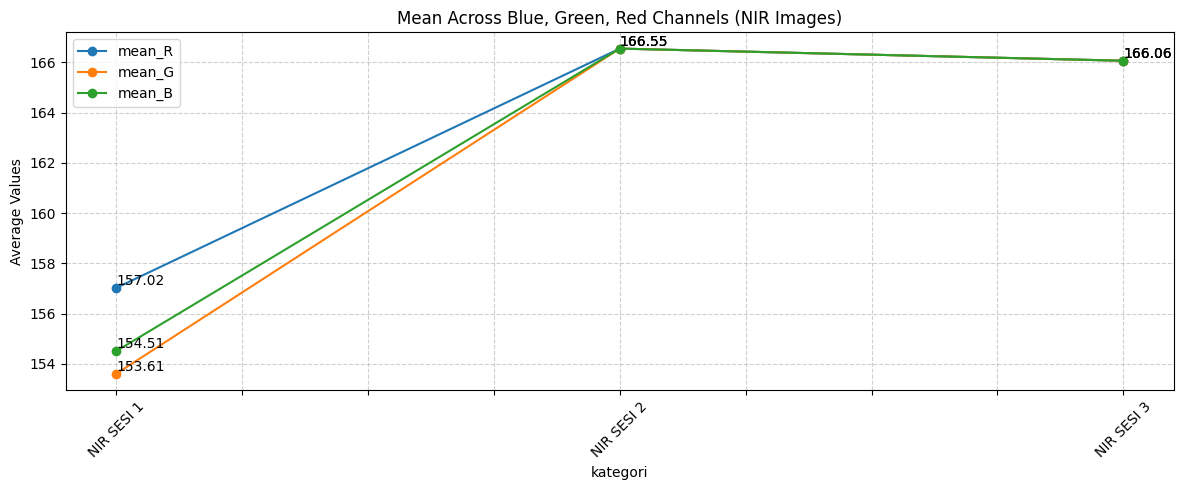

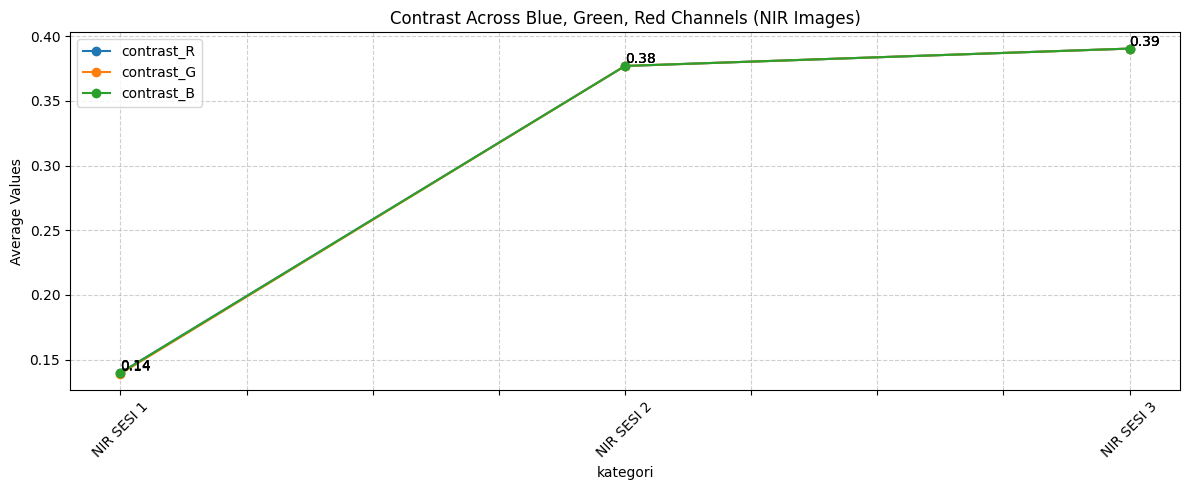

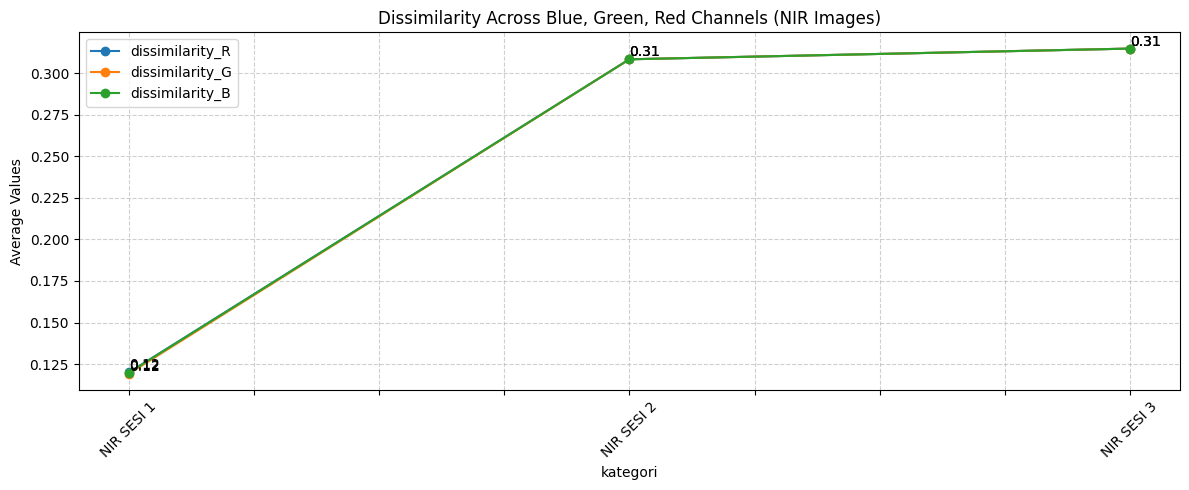

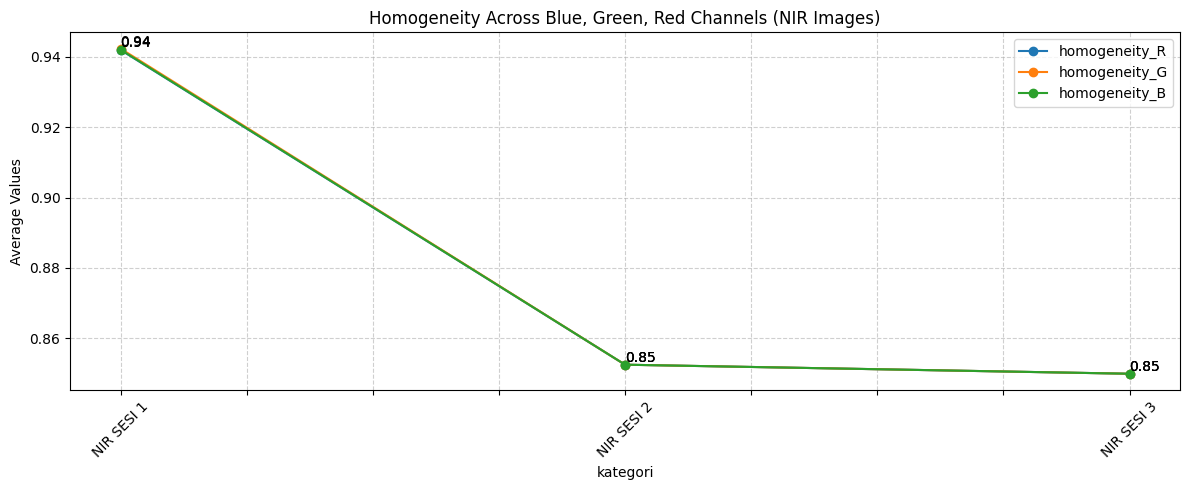

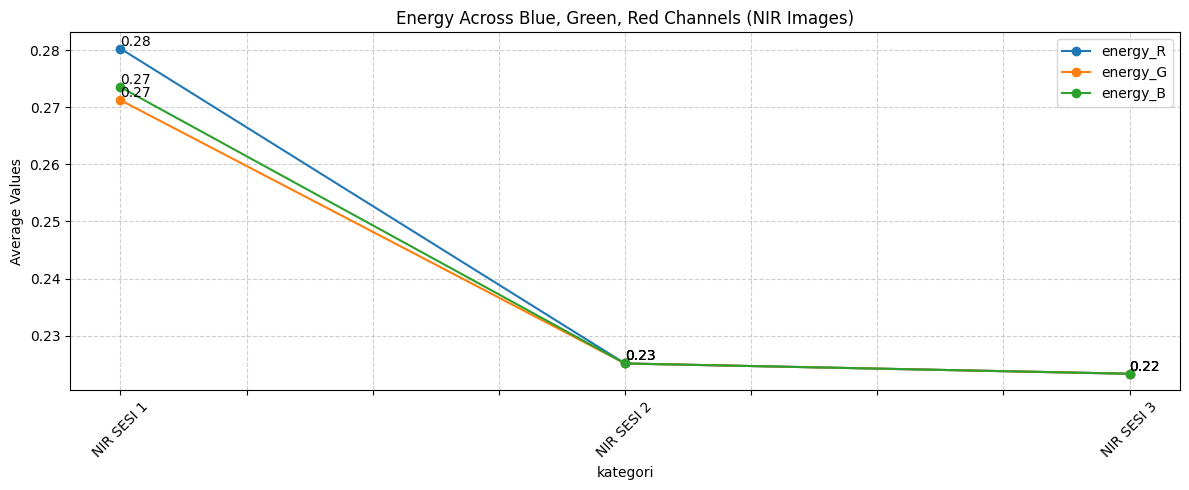

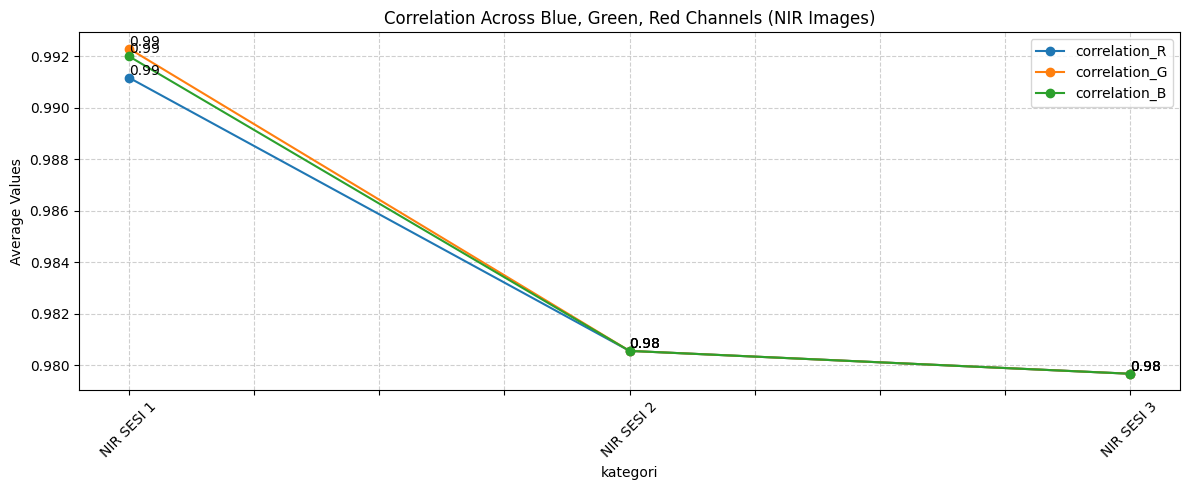

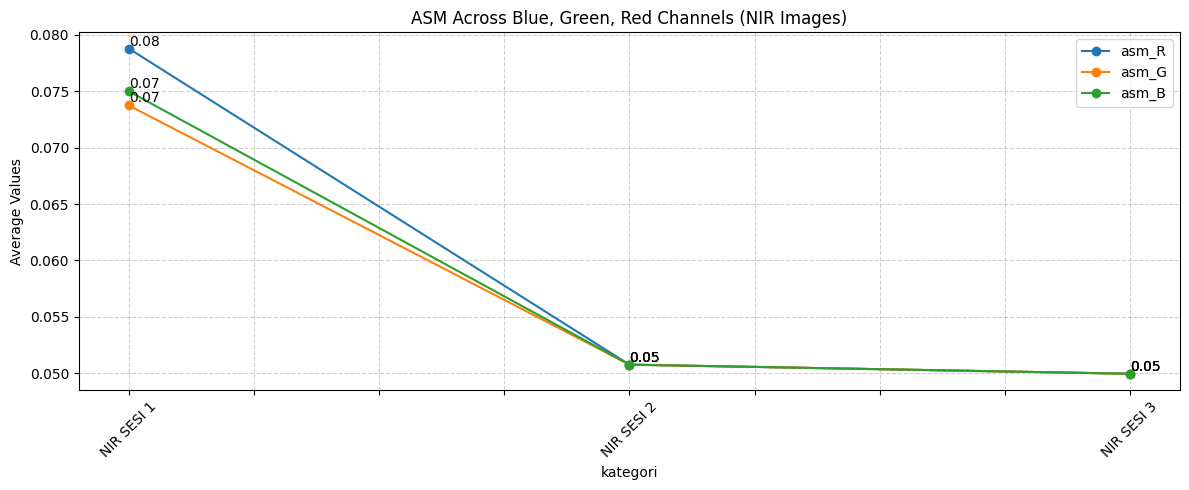

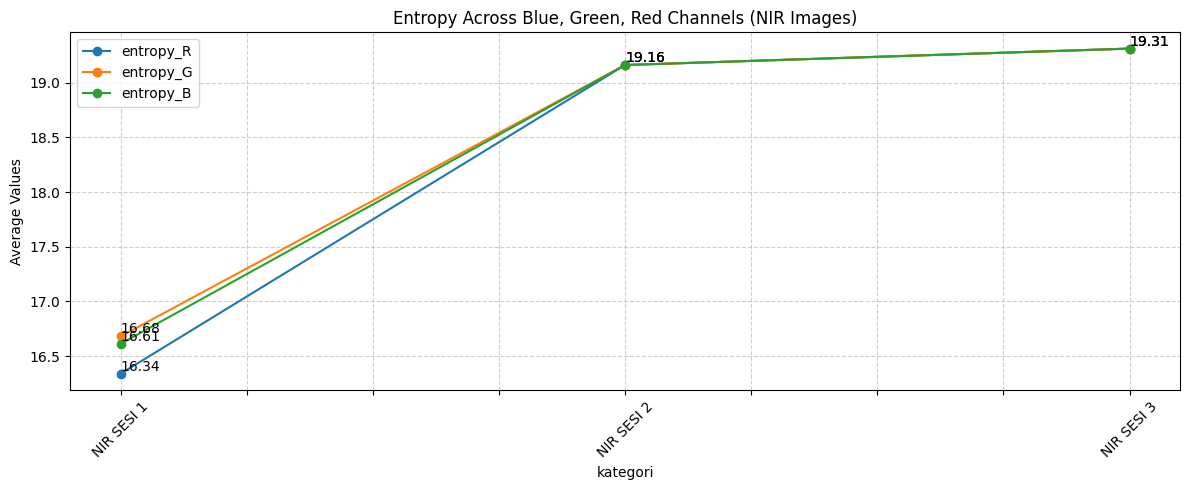

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os

# Definisikan jalur ke folder yang berisi file CSV hasil GLCM
glcm_results_folder = '/content/drive/My Drive/ComputersVision/Kelompok4/glcm_results'

# Dapatkan daftar semua file CSV di folder yang ditentukan
all_csv_files = glob.glob(os.path.join(glcm_results_folder, '*.csv'))

# Filter untuk file yang mengandung "NIR" dalam nama filenya
file_list = [f for f in all_csv_files if "NIR" in os.path.basename(f)]

# Ekstrak label dari nama file (hapus _glcm_result.csv dan jalurnya)
kategori_labels = [os.path.basename(f).replace('_glcm_result.csv', '') for f in file_list]


df_list = []
for file, label in zip(file_list, kategori_labels):
    try:
        temp = pd.read_csv(file)
        temp["kategori"] = label
        df_list.append(temp)
    except Exception as e:
        print(f"Error membaca file {file}: {e}")
        continue


if df_list:
    df = pd.concat(df_list, ignore_index=True)

    fitur_groups = {
        "Mean": ["mean_R", "mean_G", "mean_B"],
        "Contrast": ["contrast_R", "contrast_G", "contrast_B"],
        "Dissimilarity": ["dissimilarity_R", "dissimilarity_G", "dissimilarity_B"],
        "Homogeneity": ["homogeneity_R", "homogeneity_G", "homogeneity_B"],
        "Energy": ["energy_R", "energy_G", "energy_B"],
        "Correlation": ["correlation_R", "correlation_G", "correlation_B"],
        "ASM": ["asm_R", "asm_G", "asm_B"],
        "Entropy": ["entropy_R", "entropy_G", "entropy_B"]
    }

    # Definisikan urutan kategori yang diinginkan untuk plotting (berdasarkan "NIR Sesi X")
    category_order = ['NIR SESI 1', 'NIR SESI 2', 'NIR SESI 3']


    for fitur, cols in fitur_groups.items():
        # Periksa apakah kolom ada di DataFrame sebelum plotting
        valid_cols = [col for col in cols if col in df.columns]
        if not valid_cols:
            print(f"Melewati plot untuk {fitur}: Kolom {cols} tidak ditemukan di DataFrame.")
            continue

        plt.figure(figsize=(12, 5))
        # Kelompokkan berdasarkan 'kategori' dan hitung rata-rata untuk kolom yang valid
        df_grouped = df.groupby("kategori")[valid_cols].mean()

        # Atur ulang indeks DataFrame yang dikelompokkan untuk memastikan urutan yang diinginkan
        df_grouped = df_grouped.reindex(category_order)

        ax = df_grouped.plot(marker="o", ax=plt.gca())
        plt.title(f"{fitur} Across Blue, Green, Red Channels (NIR Images)")
        plt.ylabel("Average Values")
        plt.xticks(rotation=45)
        plt.grid(True, linestyle="--", alpha=0.6)

        # Tambahkan label data ke plot
        for line in ax.lines:
            for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
                plt.text(x_value, y_value, f'{y_value:.2f}', ha='left', va='bottom')


        plt.tight_layout() # Sesuaikan tata letak untuk mencegah label tumpang tindih
        plt.show()
else:
    print("Tidak ada file CSV yang valid yang mengandung 'NIR' ditemukan untuk diproses dan diplot.")

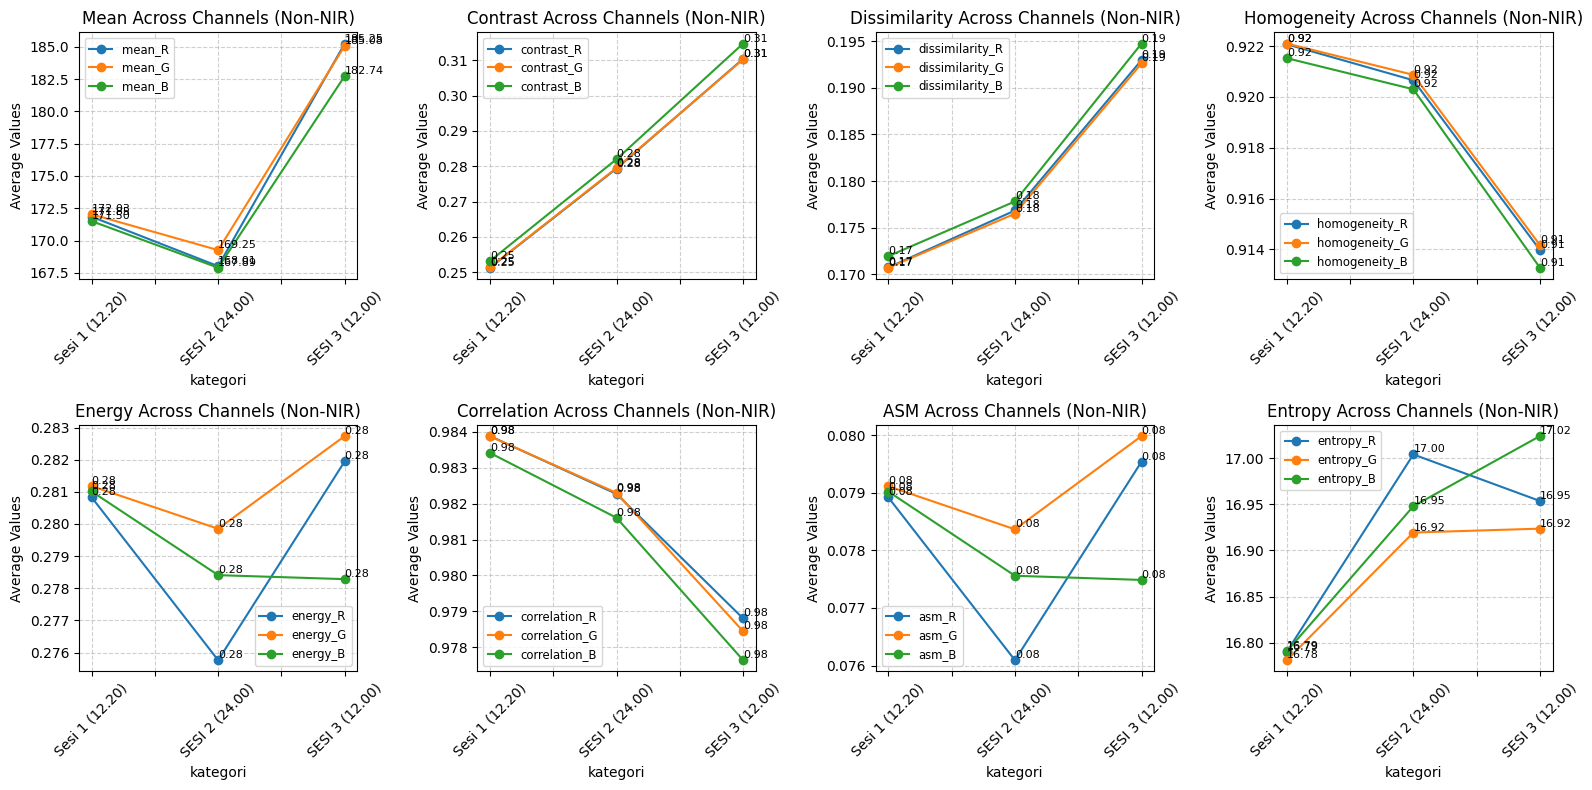

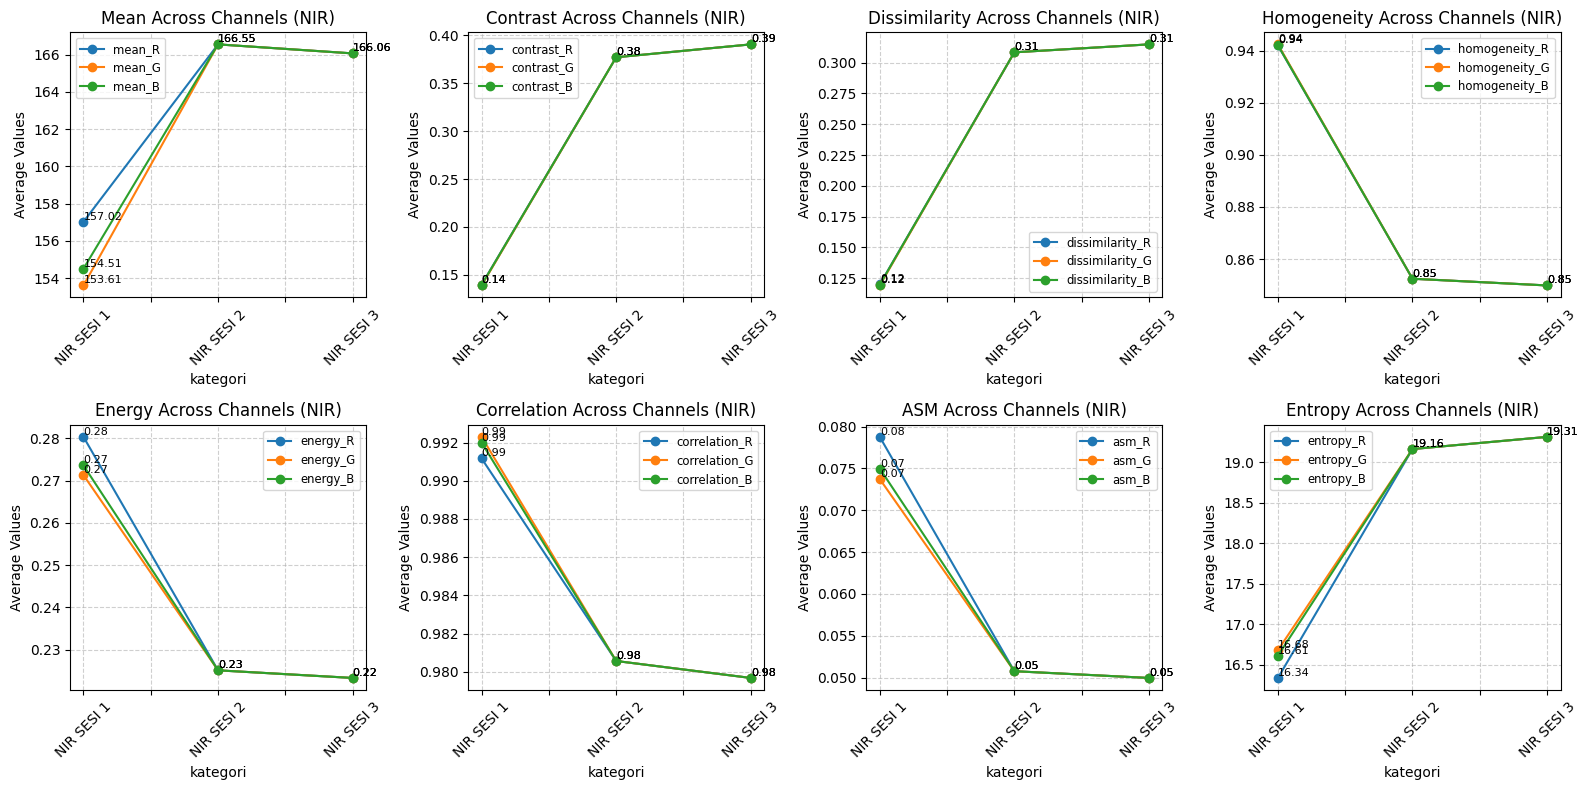

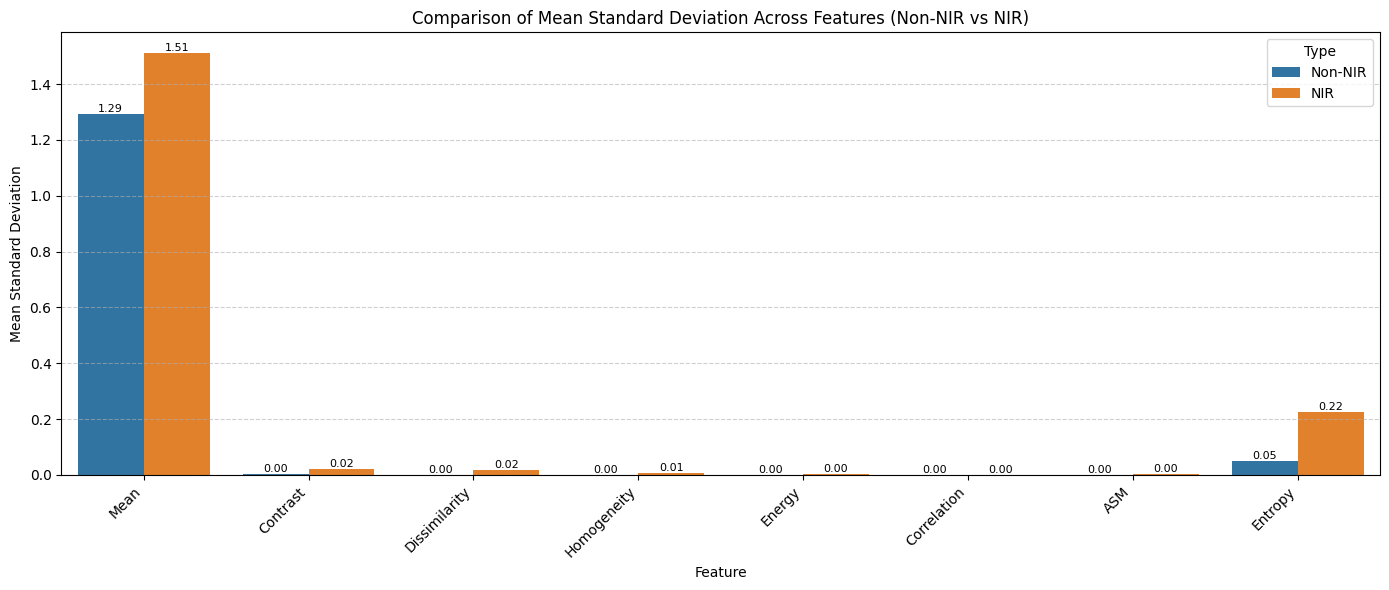

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns

# Definisikan jalur ke folder yang berisi file CSV hasil GLCM
glcm_results_folder = '/content/drive/My Drive/ComputersVision/Kelompok4/glcm_results'

# Dapatkan daftar semua file CSV di folder yang ditentukan
all_csv_files = glob.glob(os.path.join(glcm_results_folder, '*.csv'))

# Filter untuk file yang TIDAK mengandung "NIR" dalam nama filenya
non_nir_files = [f for f in all_csv_files if "NIR" not in os.path.basename(f)]

# Filter untuk file yang mengandung "NIR" dalam nama filenya
nir_files = [f for f in all_csv_files if "NIR" in os.path.basename(f)]

# Ekstrak label dari nama file
non_nir_labels = [os.path.basename(f).replace('_glcm_result.csv', '') for f in non_nir_files]
nir_labels = [os.path.basename(f).replace('_glcm_result.csv', '') for f in nir_files]

# Muat dataframes
df_list_non_nir = []
for file, label in zip(non_nir_files, non_nir_labels):
    try:
        temp = pd.read_csv(file)
        temp["kategori"] = label
        df_list_non_nir.append(temp)
    except Exception as e:
        print(f"Error membaca file {file}: {e}")

df_list_nir = []
for file, label in zip(nir_files, nir_labels):
    try:
        temp = pd.read_csv(file)
        temp["kategori"] = label
        df_list_nir.append(temp)
    except Exception as e:
        print(f"Error membaca file {file}: {e}")


# Gabungkan dataframes jika tidak kosong
df_non_nir = pd.concat(df_list_non_nir, ignore_index=True) if df_list_non_nir else pd.DataFrame()
df_nir = pd.concat(df_list_nir, ignore_index=True) if df_list_nir else pd.DataFrame()


fitur_groups = {
    "Mean": ["mean_R", "mean_G", "mean_B"],
    "Contrast": ["contrast_R", "contrast_G", "contrast_B"],
    "Dissimilarity": ["dissimilarity_R", "dissimilarity_G", "dissimilarity_B"],
    "Homogeneity": ["homogeneity_R", "homogeneity_G", "homogeneity_B"],
    "Energy": ["energy_R", "energy_G", "energy_B"],
    "Correlation": ["correlation_R", "correlation_G", "correlation_B"],
    "ASM": ["asm_R", "asm_G", "asm_B"],
    "Entropy": ["entropy_R", "entropy_G", "entropy_B"]
}

# Definisikan urutan kategori yang diinginkan untuk plotting
non_nir_category_order = ['Sesi 1 (12.20)', 'SESI 2 (24.00)', 'SESI 3 (12.00)']
nir_category_order = ['NIR SESI 1', 'NIR SESI 2', 'NIR SESI 3']


# Fungsi plotting
def plot_feature_grid(dataframe, feature_groups, category_order, title_suffix=""):
    n_features = len(feature_groups)
    n_cols = 4 # Sesuaikan jumlah kolom sesuai kebutuhan
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
    axes = axes.flatten() # Ratakan array axes untuk iterasi yang mudah

    for i, (fitur, cols) in enumerate(fitur_groups.items()):
        ax = axes[i]
        valid_cols = [col for col in cols if col in dataframe.columns]
        if not valid_cols:
            print(f"Melewati plot untuk {fitur}: Kolom {cols} tidak ditemukan di DataFrame.")
            continue

        df_grouped = dataframe.groupby("kategori")[valid_cols].mean().reindex(category_order)
        df_grouped.plot(marker="o", ax=ax)
        ax.set_title(f"{fitur} Across Channels {title_suffix}")
        ax.set_ylabel("Average Values")
        ax.tick_params(axis='x', rotation=45)
        ax.grid(True, linestyle="--", alpha=0.6)
        ax.legend(loc='best', fontsize='small')

        # Tambahkan label data ke plot
        for line in ax.lines:
            for x_value, y_value in zip(line.get_xdata(), line.get_ydata()):
                ax.text(x_value, y_value, f'{y_value:.2f}', ha='left', va='bottom', fontsize=8)


    # Sembunyikan subplot yang tidak digunakan
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

def plot_std_comparison(df_non_nir, df_nir, feature_groups, non_nir_order, nir_order):
    std_results = []
    for fitur, cols in feature_groups.items():
        valid_cols_non_nir = [col for col in cols if col in df_non_nir.columns]
        valid_cols_nir = [col for col in cols if col in df_nir.columns]

        if valid_cols_non_nir:
            std_non_nir = df_non_nir.groupby("kategori")[valid_cols_non_nir].std().mean().mean() # Rata-rata std di seluruh channel dan kategori
            std_results.append({'Feature': fitur, 'Type': 'Non-NIR', 'Std_Mean': std_non_nir})

        if valid_cols_nir:
            std_nir = df_nir.groupby("kategori")[valid_cols_nir].std().mean().mean() # Rata-rata std di seluruh channel dan kategori
            std_results.append({'Feature': fitur, 'Type': 'NIR', 'Std_Mean': std_nir})

    if std_results:
        df_std = pd.DataFrame(std_results)

        plt.figure(figsize=(14, 6))
        ax = sns.barplot(data=df_std, x='Feature', y='Std_Mean', hue='Type')
        plt.title('Comparison of Mean Standard Deviation Across Features (Non-NIR vs NIR)')
        plt.ylabel('Mean Standard Deviation')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.6)

        # Tambahkan label data ke bar plot
        for container in ax.containers:
            for bar in container:
                yval = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom', ha='center', fontsize=8)


        plt.tight_layout()
        plt.show()
    else:
        print("Tidak ada data standar deviasi untuk diplot.")


# Plot grid untuk gambar Non-NIR
if not df_non_nir.empty:
    plot_feature_grid(df_non_nir, fitur_groups, non_nir_category_order, "(Non-NIR)")
else:
    print("Tidak ada data non-NIR untuk diplot.")

# Plot grid untuk gambar NIR
if not df_nir.empty:
    plot_feature_grid(df_nir, fitur_groups, nir_category_order, "(NIR)")
else:
    print("Tidak ada data NIR untuk diplot.")

# Plot perbandingan standar deviasi
if not df_non_nir.empty or not df_nir.empty:
    plot_std_comparison(df_non_nir, df_nir, fitur_groups, non_nir_category_order, nir_category_order)
else:
    print("Tidak ada data yang tersedia untuk perbandingan standar deviasi.")

Selected sample image from NIR SESI 1: /content/drive/My Drive/ComputersVision/Kelompok4/NIR SESI 1/0_1757395749_0_1_0.jpg
Selected sample image from NIR SESI 2: /content/drive/My Drive/ComputersVision/Kelompok4/NIR SESI 2/Copy of 0_1757436094_0_1_0.jpg
Selected sample image from NIR SESI 3: /content/drive/My Drive/ComputersVision/Kelompok4/NIR SESI 3/Copy of 0_1757491332_0_1_0.jpg


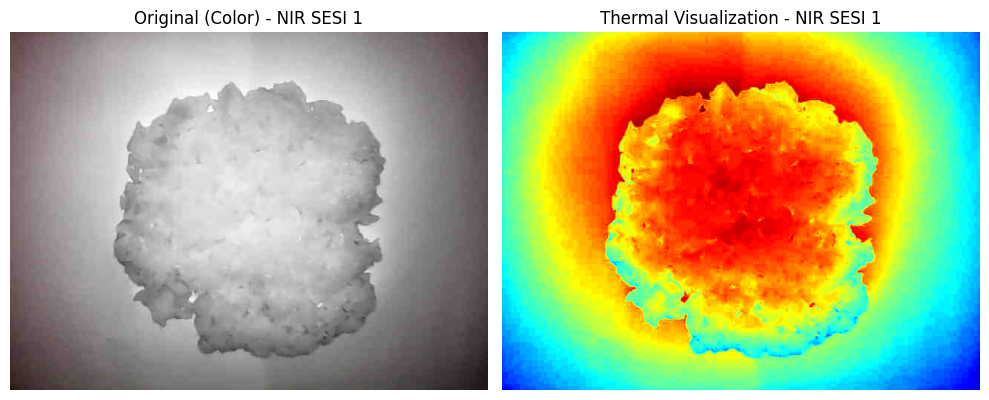

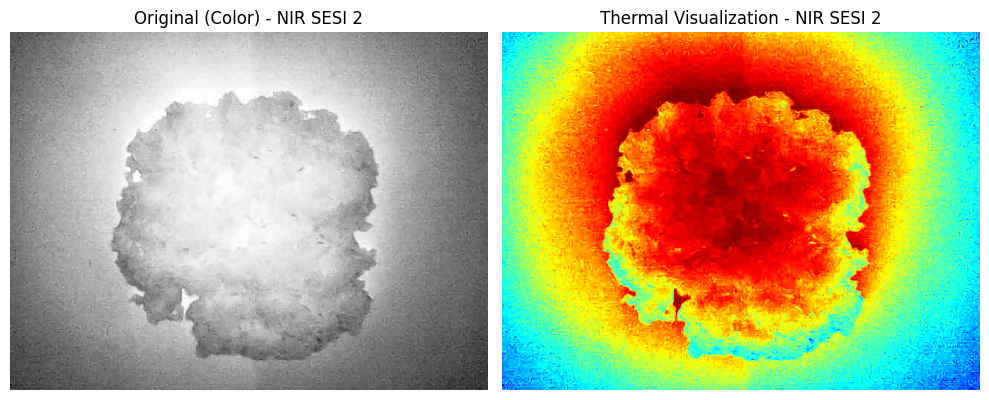

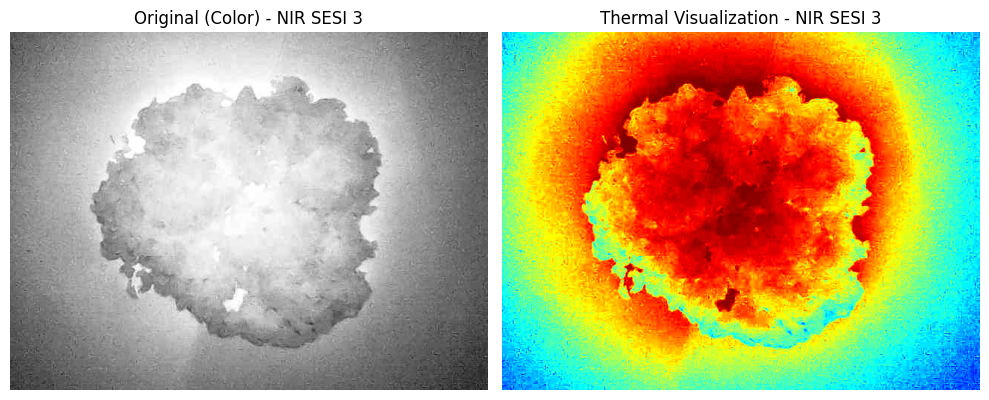

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

# Definisikan jalur folder utama yang berisi subfolder NIR
main_folder_path = '/content/drive/My Drive/ComputersVision/Kelompok4'

# Buat daftar untuk menyimpan jalur satu contoh gambar dari setiap folder NIR
sample_image_paths = []

# Iterasi melalui setiap item di folder utama
for item_name in os.listdir(main_folder_path):
    item_path = os.path.join(main_folder_path, item_name)

    # Periksa apakah itu direktori dan mengandung "NIR" dalam namanya
    if os.path.isdir(item_path) and "NIR" in item_name:
        # Dapatkan daftar semua file gambar di subfolder
        image_files = glob.glob(os.path.join(item_path, "*.png")) + \
                      glob.glob(os.path.join(item_path, "*.jpg")) + \
                      glob.glob(os.path.join(item_path, "*.jpeg")) + \
                      glob.glob(os.path.join(item_path, "*.bmp")) + \
                      glob.glob(os.path.join(item_path, "*.gif"))

        # Jika ada file gambar, ambil yang pertama sebagai contoh
        if image_files:
            sample_image_paths.append(image_files[0])
            print(f"Dipilih contoh gambar dari {item_name}: {image_files[0]}")
        else:
            print(f"Tidak ada file gambar yang ditemukan di {item_name}")

# Proses dan tampilkan representasi termal dari setiap contoh gambar
for image_path in sample_image_paths:
    try:
        # Baca gambar dalam skala abu-abu karena NIR seringkali merupakan satu channel atau direpresentasikan dalam skala abu-abu
        # Gunakan cv2.IMREAD_GRAYSCALE untuk memastikan dibaca sebagai satu channel
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Peringatan: Tidak dapat memuat gambar {image_path}. Melewati.")
            continue

        # Terapkan colormap untuk memvisualisasikan satu channel sebagai gambar termal
        # Anda dapat memilih colormap yang berbeda seperti cv2.COLORMAP_JET, cv2.COLORMAP_HOT, dll.
        thermal_image = cv2.applyColorMap(image, cv2.COLORMAP_JET)

        # Konversi gambar termal dari BGR ke RGB untuk ditampilkan dengan matplotlib
        thermal_image_rgb = cv2.cvtColor(thermal_image, cv2.COLOR_BGR2RGB)

        # Dapatkan nama folder asli untuk judul
        folder_name = os.path.basename(os.path.dirname(image_path))

        # Tampilkan gambar asli dan termal
        plt.figure(figsize=(10, 5))

        # Gambar Asli (jika awalnya berwarna, tampilkan. Jika skala abu-abu, tampilkan yang dibaca dalam skala abu-abu)
        original_display = cv2.imread(image_path) # Coba membaca dalam warna
        if original_display is None: # Jika membaca dalam warna gagal (skala abu-abu), tampilkan gambar skala abu-abu
             original_display = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB) # Konversi skala abu-abu untuk ditampilkan
             plt.subplot(1, 2, 1)
             plt.imshow(original_display)
             plt.title(f'Asli (Skala Abu-abu) - {folder_name}')
             plt.axis('off')
        else:
             original_display_rgb = cv2.cvtColor(original_display, cv2.COLOR_BGR2RGB)
             plt.subplot(1, 2, 1)
             plt.imshow(original_display_rgb)
             plt.title(f'Asli (Berwarna) - {folder_name}')
             plt.axis('off')


        plt.subplot(1, 2, 2)
        plt.imshow(thermal_image_rgb)
        plt.title(f'Visualisasi Termal - {folder_name}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error memproses atau menampilkan {image_path}: {e}")

Selected sample image from NIR SESI 1: /content/drive/My Drive/ComputersVision/Kelompok4/NIR SESI 1/0_1757395749_0_1_0.jpg
Selected sample image from NIR SESI 2: /content/drive/My Drive/ComputersVision/Kelompok4/NIR SESI 2/Copy of 0_1757436094_0_1_0.jpg
Selected sample image from NIR SESI 3: /content/drive/My Drive/ComputersVision/Kelompok4/NIR SESI 3/Copy of 0_1757491332_0_1_0.jpg


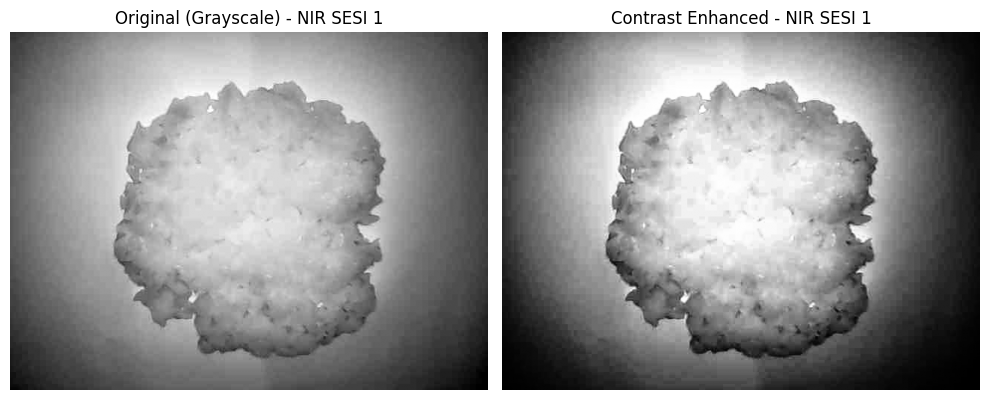

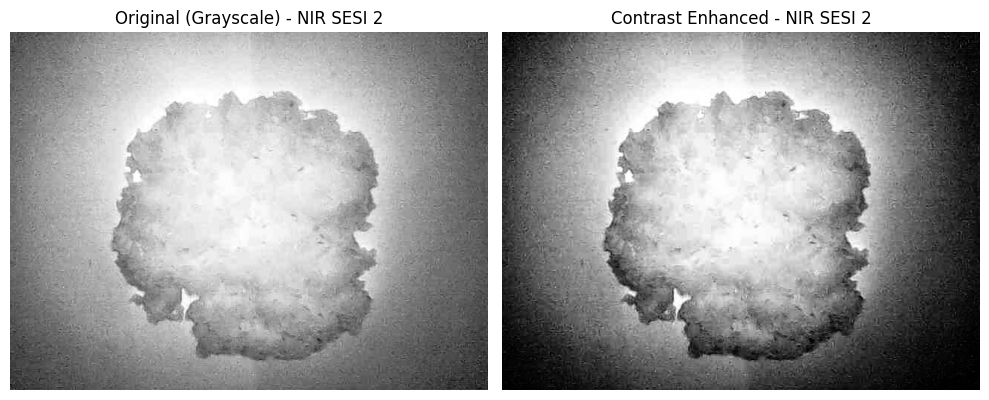

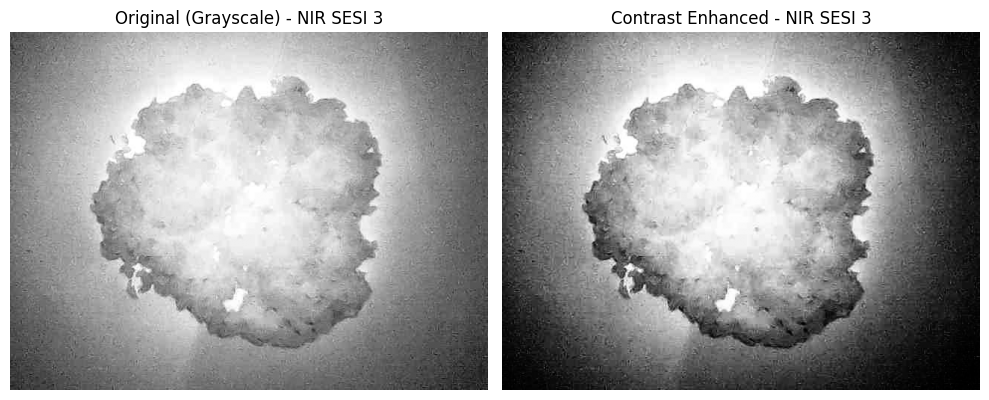

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import glob

# Definisikan jalur folder utama yang berisi subfolder NIR
main_folder_path = '/content/drive/My Drive/ComputersVision/Kelompok4'

# Buat daftar untuk menyimpan jalur satu contoh gambar dari setiap folder NIR
sample_image_paths = []

# Iterasi melalui setiap item di folder utama
for item_name in os.listdir(main_folder_path):
    item_path = os.path.join(main_folder_path, item_name)

    # Periksa apakah itu direktori dan mengandung "NIR" dalam namanya
    if os.path.isdir(item_path) and "NIR" in item_name:
        # Dapatkan daftar semua file gambar di subfolder
        image_files = glob.glob(os.path.join(item_path, "*.png")) + \
                      glob.glob(os.path.join(item_path, "*.jpg")) + \
                      glob.glob(os.path.join(item_path, "*.jpeg")) + \
                      glob.glob(os.path.join(item_path, "*.bmp")) + \
                      glob.glob(os.path.join(item_path, "*.gif"))

        # Jika ada file gambar, ambil yang pertama sebagai contoh
        if image_files:
            sample_image_paths.append(image_files[0])
            print(f"Dipilih contoh gambar dari {item_name}: {image_files[0]}")
        else:
            print(f"Tidak ada file gambar yang ditemukan di {item_name}")

# Proses dan tampilkan peningkatan kontras dari setiap contoh gambar
for image_path in sample_image_paths:
    try:
        # Baca gambar dalam skala abu-abu
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Peringatan: Tidak dapat memuat gambar {image_path}. Melewati.")
            continue

        # Terapkan ekualisasi histogram untuk peningkatan kontras
        enhanced_image = cv2.equalizeHist(image)

        # Dapatkan nama folder asli untuk judul
        folder_name = os.path.basename(os.path.dirname(image_path))

        # Tampilkan gambar asli dan yang ditingkatkan
        plt.figure(figsize=(10, 5))

        # Gambar Asli (Skala Abu-abu)
        plt.subplot(1, 2, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Asli (Skala Abu-abu) - {folder_name}')
        plt.axis('off')

        # Gambar yang Ditingkatkan
        plt.subplot(1, 2, 2)
        plt.imshow(enhanced_image, cmap='gray')
        plt.title(f'Kontras Ditingkatkan - {folder_name}')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error memproses atau menampilkan {image_path}: {e}")

## Data preparation

Load and preprocess the images from the specified folders, assigning labels based on the folder names. Split the data into training and testing sets.


In [ ]:
pip install tensorflow

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Definisikan jalur dasar ke folder gambar
base_path = '/content/drive/My Drive/ComputersVision/Kelompok4/augmentasi'

# Buat kamus untuk memetakan nama folder ke label numerik dengan label yang diperbarui
label_map = {
    "Sesi 1 (12.20)": 0,  # Nasi Fresh
    "SESI 2 (24.00)": 1,  # Nasi Kurang Fresh
    "SESI 3 (12.00)": 2   # Basi
}

# Inisialisasi daftar kosong untuk menyimpan data gambar (X) dan label yang sesuai (y)
X = []
y = []

# Definisikan ukuran gambar target
image_size = (128, 128)

# Iterasi melalui setiap folder di jalur dasar
for folder_name in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder_name)

    # Periksa apakah itu direktori dan ada dalam peta label kita
    if os.path.isdir(folder_path) and folder_name in label_map:
        label = label_map[folder_name]
        print(f"Memproses folder: {folder_name} dengan label {label}")

        # Iterasi melalui file gambar di folder
        for filename in os.listdir(folder_path):
            if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
                image_path = os.path.join(folder_path, filename)

                # Baca gambar menggunakan OpenCV
                image = cv2.imread(image_path)

                if image is None:
                    print(f"Peringatan: Tidak dapat memuat gambar {image_path}. Melewati.")
                    continue

                # Ubah ukuran gambar
                resized_image = cv2.resize(image, image_size)

                # Tambahkan gambar yang diubah ukurannya dan label ke daftar
                X.append(resized_image)
                y.append(label)

# Konversi daftar ke array NumPy
X = np.array(X)
y = np.array(y)

# Normalisasi data gambar
X = X.astype('float32') / 255.0

# Konversi label numerik ke label kategorikal one-hot encoded
y = to_categorical(y, num_classes=len(label_map))

# Bagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Total gambar yang dimuat: {len(X)}")
print(f"Bentuk X: {X.shape}")
print(f"Bentuk y: {y.shape}")
print(f"Bentuk X_train: {X_train.shape}")
print(f"Bentuk X_test: {X_test.shape}")
print(f"Bentuk y_train: {y_train.shape}")
print(f"Bentuk y_test: {y_test.shape}")

Processing folder: Sesi 1 (12.20) with label 0
Processing folder: SESI 2 (24.00) with label 1
Processing folder: SESI 3 (12.00) with label 2
Total images loaded: 660
Shape of X: (660, 128, 128, 3)
Shape of y: (660, 3)
Shape of X_train: (528, 128, 128, 3)
Shape of X_test: (132, 128, 128, 3)
Shape of y_train: (528, 3)
Shape of y_test: (132, 3)


## Model building

Define a CNN model architecture suitable for image classification.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Definisikan bentuk input berdasarkan gambar yang telah diproses sebelumnya
input_shape = (image_size[0], image_size[1], 3) # Tinggi, Lebar, Channels

# Bangun model CNN
model = Sequential()

# Layer Konvolusional 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

# Layer Konvolusional 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Layer Konvolusional 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Ratakan output untuk layer dense
model.add(Flatten())

# Layer Dense
model.add(Dense(128, activation='relu'))

# Layer Dropout untuk regularisasi
model.add(Dropout(0.5))

# Layer Output
# Jumlah unit sama dengan jumlah kelas (fresh, less fresh, stale)
model.add(Dense(len(label_map), activation='softmax'))

# Cetak ringkasan model
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## Model compilation

Compile the CNN model with an appropriate optimizer, loss function, and metrics.


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Compile model
model.compile(optimizer=Adam(),
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

print("Model compiled successfully.")

Model compiled successfully.


## Model training

Train the CNN model using the prepared training data.


In [ ]:
# Mentraining Model
epochs = 20
batch_size = 32

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test))

print("Model training completed.")

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.3462 - loss: 1.2925 - val_accuracy: 0.3333 - val_loss: 1.1012
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.3620 - loss: 1.1007 - val_accuracy: 0.4167 - val_loss: 1.0988
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3533 - loss: 1.0991 - val_accuracy: 0.3182 - val_loss: 1.0978
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 998ms/step - accuracy: 0.3559 - loss: 1.0964 - val_accuracy: 0.3258 - val_loss: 1.0978
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.3443 - loss: 1.0882 - val_accuracy: 0.3485 - val_loss: 1.0989
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.3766 - loss: 1.0914 - val_accuracy: 0.3939 - val_loss: 1.0969
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4142 - loss: 1.0932 - val_accuracy: 0.3561 - val_loss: 1.0941
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - accuracy: 0.4682 - loss: 1.0747 - val_accuracy: 0.3333 - val_lo

## Model evaluation

### Subtask:
Evaluate the trained model's performance on the test data.


In [ ]:
# Evaluate the model on the entire dataset
evaluation_results = model.evaluate(X, y, verbose=0)

# Print the evaluation results
print(f"Overall Loss: {evaluation_results[0]:.4f}")
print(f"Overall Accuracy: {evaluation_results[1]:.4f}")

Overall Loss: 0.4401
Overall Accuracy: 0.8500


## Model Evaluasi


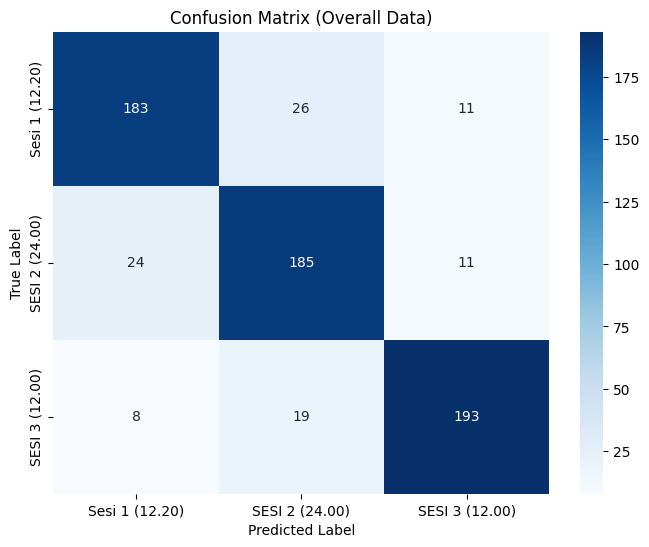

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Menampilkan Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix (Overall Data)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step
Confusion Matrix (Overall Data):
[[183  26  11]
 [ 24 185  11]
 [  8  19 193]]

Classification Report (Overall Data):
                precision    recall  f1-score   support

Sesi 1 (12.20)       0.85      0.83      0.84       220
SESI 2 (24.00)       0.80      0.84      0.82       220
SESI 3 (12.00)       0.90      0.88      0.89       220

      accuracy                           0.85       660
     macro avg       0.85      0.85      0.85       660
  weighted avg       0.85      0.85      0.85       660



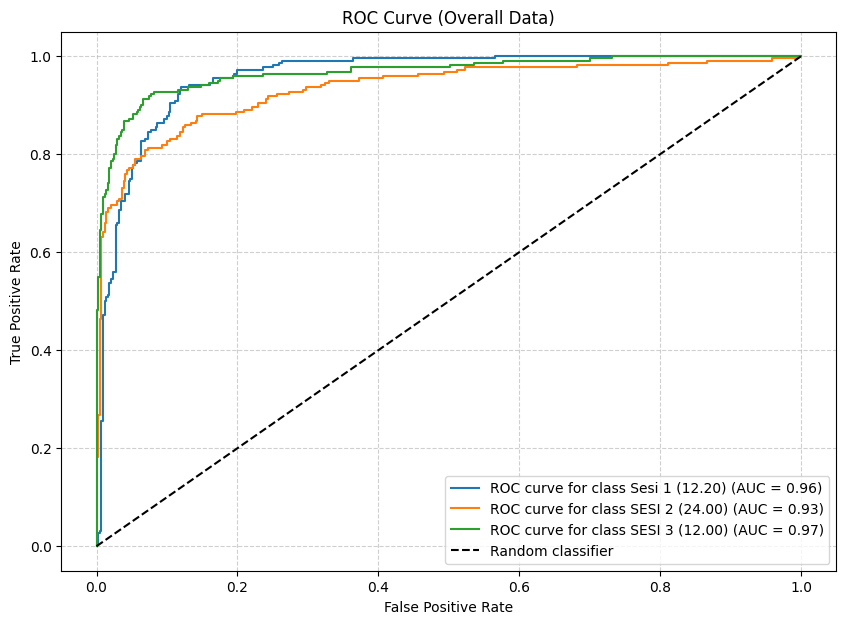

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Dapatkan prediksi model pada seluruh dataset
y_pred_probs = model.predict(X)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y, axis=1)

# Hitung dan cetak confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (Data Keseluruhan):")
print(conf_matrix)

# Hitung dan cetak classification report (termasuk F1-score dan Recall)
# Definisikan nama target secara eksplisit berdasarkan kunci label_map
target_names = list(label_map.keys())
class_report = classification_report(y_true, y_pred, target_names=target_names)
print("\nClassification Report (Data Keseluruhan):")
print(class_report)

# Hitung kurva ROC dan AUC untuk setiap kelas
plt.figure(figsize=(10, 7))

# Iterasi melalui setiap kelas untuk memplot kurva ROC-nya
for i in range(len(target_names)):
    fpr, tpr, _ = roc_curve(y[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Kurva ROC untuk kelas {target_names[i]} (AUC = {roc_auc:.2f})')

# Plot garis diagonal (klasifikasi acak)
plt.plot([0, 1], [0, 1], 'k--', label='Klasifikasi acak')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Kurva ROC (Data Keseluruhan)')
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Model Saving

Save the trained CNN model to a file.

In [ ]:
# Define the path to save the model
model_save_path = '/content/drive/My Drive/ComputersVision/Kelompok4/rice_classification_model.h5'

# Save the model
model.save(model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to /content/drive/My Drive/ComputersVision/Kelompok4/rice_classification_model.h5


## Load the trained model

Load the previously saved CNN model from the file.

In [ ]:
import tensorflow as tf

# Define the path where the model was saved
model_save_path = '/content/drive/My Drive/ComputersVision/Kelompok4/rice_classification_model.h5'

# Load the model
loaded_model = tf.keras.models.load_model(model_save_path)

print("Model loaded successfully.")

Model loaded successfully.


## Classify a new image

Allow the user to upload an image and then classify it using the loaded model.

Saving 0_1757395367_0_1_0.jpg to 0_1757395367_0_1_0.jpg
Uploaded file: 0_1757395367_0_1_0.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step

Predicted class: Sesi 1 (12.20)
Class probabilities:
  Sesi 1 (12.20): 0.8270
  SESI 2 (24.00): 0.1681
  SESI 3 (12.00): 0.0049


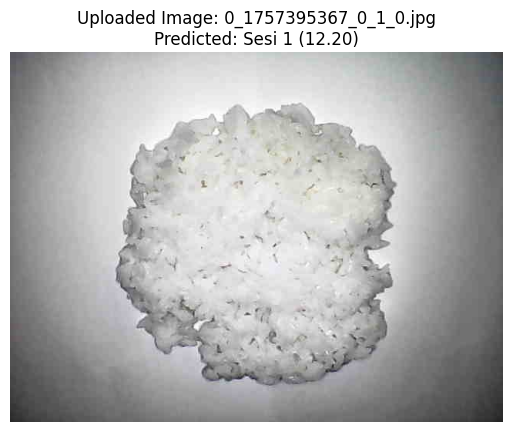

In [ ]:
from google.colab import files
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to preprocess a single image for prediction
def preprocess_image_for_prediction(image_path, target_size=(128, 128)):
    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not load image {image_path}")
        return None

    # Resize the image
    resized_image = cv2.resize(image, target_size)

    # Normalize the image data
    normalized_image = resized_image.astype('float32') / 255.0

    # Expand dimensions to match the model's input shape (add batch dimension)
    processed_image = np.expand_dims(normalized_image, axis=0)

    return processed_image

# Function to predict the class of an image
def predict_image_class(model, image_array, label_map):
    # Get the model's prediction (probabilities for each class)
    predictions = model.predict(image_array)

    # Get the index of the class with the highest probability
    predicted_class_index = np.argmax(predictions, axis=1)[0]

    # Map the index back to the class label
    # We need to reverse the label_map to get the class name from the index
    index_to_label = {v: k for k, v in label_map.items()}
    predicted_label = index_to_label[predicted_class_index]

    return predicted_label, predictions[0]

# Allow the user to upload an image
uploaded = files.upload()

# Process the uploaded image
for filename in uploaded.keys():
    print(f'Uploaded file: {filename}')

    # Define the path to the uploaded file
    uploaded_image_path = filename

    # Preprocess the uploaded image
    processed_image = preprocess_image_for_prediction(uploaded_image_path)

    if processed_image is not None:
        # Define the label map (must be the same as used during training)
        label_map = {
            "Sesi 1 (12.20)": 0,  # Nasi Fresh
            "SESI 2 (24.00)": 1,  # Nasi Kurang Fresh
            "SESI 3 (12.00)": 2   # Basi
        }

        # Predict the class of the image
        predicted_label, probabilities = predict_image_class(loaded_model, processed_image, label_map)

        print(f"\nPredicted class: {predicted_label}")
        print("Class probabilities:")
        for label, prob in zip(label_map.keys(), probabilities):
            print(f"  {label}: {prob:.4f}")

        # Display the uploaded image
        img = Image.open(uploaded_image_path)
        plt.imshow(img)
        plt.title(f"Uploaded Image: {filename}\nPredicted: {predicted_label}")
        plt.axis('off')
        plt.show()